# Learning Uncertainty Sets

In [369]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
import ot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "blue", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "red"]

### Example 2: Larger newsvendor problem
We now consider a larger Newsvendor problem, with two sets of products. 
The robust problem is 
\begin{equation*}
	\begin{array}{ll}
		\text{minimize} & \tau + y\\
		\text{subject to} & k_1^Tx_1 - p_1^T\min\{x_1, u\} \le \tau \quad \forall u \in \mathcal{U}(\theta) \\
		& k_2^Tx_2 - p_2^T\min\{x_2, u\} \le y \quad \forall u \in \mathcal{U}(\theta) \\
		& x_1 \geq x_2 \geq 0.
	\end{array}
\end{equation*}

In [380]:
# Formulate constants
n = 5
N = 300
np.random.seed(20)
k = npr.uniform(2,5,n)
p = k + npr.uniform(0.5,2,n)
# p = k + np.linspace(2,0.5,n)
k1 = npr.uniform(1,3,n)
p1 = k1 + npr.uniform(0,2,n)
# p1 = k1 + np.linspace(3,1,n)
k_tch = torch.tensor(k, requires_grad = True)
# p_tch = torch.tensor(p, requires_grad = True)
k1_tch = torch.tensor(k1, requires_grad = True)
p1_tch = torch.tensor(p1, requires_grad = True)



def loss(t,y,x_r, x_1, p_tch, alpha, data,l=1000, quantile = 0.95, target = 0.):
    Nsample = data.shape[0]
    sums =  torch.mean(torch.maximum(torch.maximum(
        torch.maximum(k_tch@x_r -data@p_tch, k_tch@x_r - p_tch@x_r) - t-alpha, 
        torch.tensor(0.,requires_grad = True)), 
        torch.maximum(k1_tch@x_1 -data@p1_tch, k1_tch@x_1 - p1_tch@x_1) - y-alpha))
    sums = sums/(1-quantile) + alpha
    sums1 = torch.mean(torch.maximum(k_tch@torch.tensor(x_r) -torch.tensor(data)@p_tch, k_tch@torch.tensor(x_r) - p_tch@torch.tensor(x_r))+ torch.maximum(k1_tch@torch.tensor(x_1) -torch.tensor(data)@p1_tch, k1_tch@torch.tensor(x_1) - p1_tch@torch.tensor(x_1)))
    return t +y + l*(sums - target), sums1, torch.sum((torch.maximum(torch.maximum(
        torch.maximum(k_tch@x_r -data@p_tch, k_tch@x_r - p_tch@x_r) - t, 
        torch.tensor(0.,requires_grad = True)), 
        torch.maximum(k1_tch@x_1 -data@p1_tch, k1_tch@x_1 - p1_tch@x_1) - y))>= torch.tensor(1.))/Nsample, sums.detach().numpy()


def gen_demand(n, N, seed=399):
    np.random.seed(seed)
    F = np.random.normal(size = (n,3))
    sig = 0.1*F@(F.T)
    # mu = np.random.uniform(-0.2,2,n)
    mu = np.linspace(-0.1,1,n)
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return mu, sig, d_train

# Generate data
mu, sig, data = gen_demand(n,N*2)

scenarios = {}
num_scenarios = 5
for scene in range(num_scenarios):
    np.random.seed(scene+1)
    scenarios[scene] = {}
    scenarios[scene][0] = np.maximum(k,p + np.random.normal(0,0.1,n))
    
# cur_ind = 5
# # A_y = {}
# A_y[cur_ind] = {}
# A_y[cur_ind][0] = A_fin
# A_y[cur_ind][1] = b_fin
# # A_y[cur_ind][2] = result3.A
# # A_y[cur_ind][3] = result3.b

# # dfs = {}
# dfs[cur_ind] = {}
# dfs[cur_ind][0] = dfgrid
# dfs[cur_ind][1] = dfgrid2

In [381]:
np.random.seed(16)
# data = np.exp(np.random.multivariate_normal(mu,sig, N*2))
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x_r = cp.Variable(n)
x_1 = cp.Variable(n)
t = cp.Variable()
y = cp.Variable()
p = cp.Parameter(n)
# p1 = cp.Parameter(n)
p.value = scenarios[1][0]
# p1.value = scenarios[0][1]
objective = cp.Minimize(t+y)

# constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
# constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]
constraints = [cp.maximum(k@x_r - p@x_r - t, k@x_r - p@u - t,k1@x_1 - p1@x_1 - y,  k1@x_1 - p1@u - y) <= 0]

constraints += [x_1 >= 0, x_r >= x_1]

prob = lropt.RobustProblem(objective, constraints)
target = -0.05
test_p = 0.5
s = 5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
# init= np.eye(n)
init_bval = -init@np.mean(train, axis=0)
# Train A and b
result1 = prob.train(lr = 0.00001, step=200, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False,init_lam = 0.1, target_cvar = target, init_alpha = 0., test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.01)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

# result3 = prob.train(eps = True, lr = 0.00001, step=800, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_mu = 1, init_lam = 0,  target_cvar = target, init_alpha =0.,mu_multiplier = 1.01,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
# df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.concatenate((np.linspace(0.01, 0.9, 60), np.linspace(0.93, 10, 30))), init_A = init, init_b = init_bval, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

result5 = prob.grid(epslst = np.concatenate((np.linspace(0.01, 0.6, 60), np.linspace(0.61, 10, 30))), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

In [357]:
u = lropt.UncertainParameter(n,
                            uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                            rho=1, A = A_fin, b=b_fin))

# Formulate the Robust Problem
x_r = cp.Variable(n)
x_1 = cp.Variable(n)
t = cp.Variable()
y = cp.Variable()
p = cp.Parameter(n)
# p1 = cp.Parameter(n)
p.value = scenarios[0][0]
# p1.value = scenarios[0][1]
objective = cp.Minimize(t+y)

constraints = [cp.maximum(k@x_r - p@x_r - t, k@x_r - p@u - t,k1@x_1 - p1@x_1 - y,  k1@x_1 - p1@u - y) <= 0]
# constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
# constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]

constraints += [x_1 >= 0, x_r >= x_1, x_r >= 0]

prob = lropt.RobustProblem(objective, constraints)
newprob = prob.dualize_constraints()
newprob.solve()
torch.mean(torch.maximum(k_tch@torch.tensor(x_r.value) -torch.tensor(test)@torch.tensor(p.value), k_tch@torch.tensor(x_r.value) - torch.tensor(p.value)@torch.tensor(x_r.value))+ torch.maximum(k1_tch@torch.tensor(x_1.value) -torch.tensor(test)@p1_tch, k1_tch@torch.tensor(x_1.value) - p1_tch@torch.tensor(x_1.value))),x_r.value, x_1.value, t.value, y.value, prob.objective.value


(tensor(-87.0133, dtype=torch.float64, grad_fn=<MeanBackward0>),
 array([1.57287789e-10, 6.92973499e-11, 1.26690724e-10, 2.18827504e-10,
        1.04678208e-09, 2.65762398e-10, 5.74346818e+00, 3.51970599e-10,
        2.54729347e-10, 2.61897104e+01, 9.98626190e-10, 1.70289199e-10,
        2.12057664e-10, 9.67932541e-11, 1.35878883e-10]),
 array([1.29885243e-10, 4.65216243e-11, 1.76665439e-10, 2.39417345e-10,
        1.03518797e-10, 2.73142863e-10, 7.29257386e-10, 2.91012116e-10,
        2.71138753e-10, 2.61897104e+01, 2.52455066e-10, 1.85480635e-10,
        2.47612758e-10, 1.12134455e-10, 1.69420248e-10]),
 array(-31.93225023),
 array(-18.34904355),
 -50.28129378253193)

In [358]:
u = lropt.UncertainParameter(n,
                            uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                            rho=1., A = init, b=init_bval))                                                     
# Formulate the Robust Problem
x_r = cp.Variable(n)
x_1 = cp.Variable(n)
t = cp.Variable()
y = cp.Variable()
p = cp.Parameter(n)
# p1 = cp.Parameter(n)
p.value = scenarios[0][0]
# p1.value = scenarios[0][1]
objective = cp.Minimize(t+y)

constraints = [cp.maximum(k@x_r - p@x_r - t, k@x_r - p@u - t,k1@x_1 - p1@x_1 - y,  k1@x_1 - p1@u - y) <= 0]
# constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
# constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]

constraints += [x_1 >= 0, x_r >= x_1, x_r >= 0]

prob = lropt.RobustProblem(objective, constraints)
newprob = prob.dualize_constraints()
newprob.solve()
torch.mean(torch.maximum(k_tch@torch.tensor(x_r.value) -torch.tensor(test)@torch.tensor(p.value), k_tch@torch.tensor(x_r.value) - torch.tensor(p.value)@torch.tensor(x_r.value))+ torch.maximum(k1_tch@torch.tensor(x_1.value) -torch.tensor(test)@p1_tch, k1_tch@torch.tensor(x_1.value) - p1_tch@torch.tensor(x_1.value))),x_r.value, x_1.value, t.value, y.value, prob.objective.value

(tensor(-80.0782, dtype=torch.float64, grad_fn=<MeanBackward0>),
 array([6.68237927e-11, 3.27676339e-11, 8.17685444e-11, 7.70820422e-11,
        2.47822869e-10, 1.23978198e-10, 6.82445905e+00, 1.46205527e-10,
        9.17818610e-11, 3.12090642e+01, 2.35959538e-10, 8.48757335e-11,
        1.15640261e-10, 5.63831868e-11, 8.02106720e-11]),
 array([3.39904466e-11, 1.03016299e-11, 4.58081720e-11, 6.29294496e-11,
        2.99204885e-11, 6.88554645e-11, 8.55763558e-11, 8.93320217e-11,
        6.99370303e-11, 3.12090642e+01, 9.06212208e-11, 4.63542038e-11,
        6.18830472e-11, 2.71785936e-11, 4.25826468e-11]),
 array(-1.18748159),
 array(14.95750493),
 13.770023340426814)

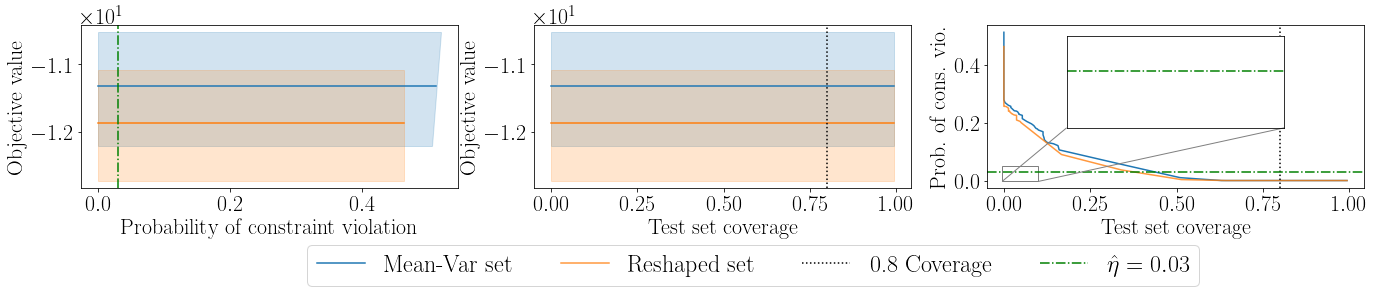

In [382]:
plot_coverage_all(dfgrid,dfgrid2, None, "News5",ind_1=(0,400),ind_2=(0,400),logscale = False, zoom = True, legend = True)

In [363]:
def mro(train, test, K = 300, rho = 1):
    vios = np.zeros((num_scenarios))
    vios_1 = np.zeros((num_scenarios))
    objs = np.zeros((num_scenarios))
    time = np.zeros((num_scenarios))
    for scene in range(num_scenarios):
        u = lropt.UncertainParameter(n,
                                          uncertainty_set = lropt.MRO(train = False, data = train, rho = rho, A = None, K = K))
            # Formulate the Robust Problem
        x_r = cp.Variable(n)
        x_1 = cp.Variable(n)
        t = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter(n)
        # p1 = cp.Parameter(n)
        p.value = scenarios[scene][0]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t+y)

        constraints = [cp.maximum(k@x_r - p@x_r - t, k@x_r - p@u - t,k1@x_1 - p1@x_1 - y,  k1@x_1 - p1@u - y) <= 0]

        constraints += [x_1 >= 0, x_r >= x_1, x_r >= 0]


        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        objs[scene] = torch.mean(
        torch.maximum(k_tch@torch.tensor(x_r.value) -torch.tensor(test)@torch.tensor(p.value), k_tch@torch.tensor(x_r.value) - torch.tensor(p.value)@torch.tensor(x_r.value))+ torch.maximum(k1_tch@torch.tensor(x_1.value) -torch.tensor(test)@p1_tch, k1_tch@torch.tensor(x_1.value) - p1_tch@torch.tensor(x_1.value)))
        vios[scene] = eval(t.value,y.value,x_r.value, x_1.value,p1,p.value,test).item()
        vios_1[scene] = eval(t.value,y.value,x_r.value, x_1.value,p1,p.value,train).item()
        time[scene] = newprob.solver_stats.solve_time
    return vios, vios_1, objs, time

In [389]:
#n=15,0.6, n=10,1.3, n=5
v,_,o,_ = mro(train, test, K = 300, rho = 0.55)
np.mean(v),np.mean(o),np.mean(np.hstack(dfgrid2["Test_val"]),axis = 0)

(0.02666666656732559, -13.04816417296964, -11.861021280452748)

In [383]:
dists = []
for i in range(20): 
  seed = i
  data = np.exp(np.random.multivariate_normal(mu,sig, N*2))
  train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
  M = ot.dist(test,train, metric='euclidean')
  dists.append(ot.emd2(a = [], b= [], M=M))
np.mean(dists)

0.3896876244794051

In [390]:
def wass_dist(train, test, epsilon):
  ind = 0
  for i in test:
      for j in train:
          if np.linalg.norm(i - j,2) <= epsilon:
             ind += 1
             break
  return ind/(np.shape(train)[0])

wassdists = []
for i in range(20):
  seed = i 
  data = np.exp(np.random.multivariate_normal(mu,sig, N*2))
  train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
  wassdists.append(wass_dist(train, test,0.55))
np.mean(wassdists)

0.9193333333333336

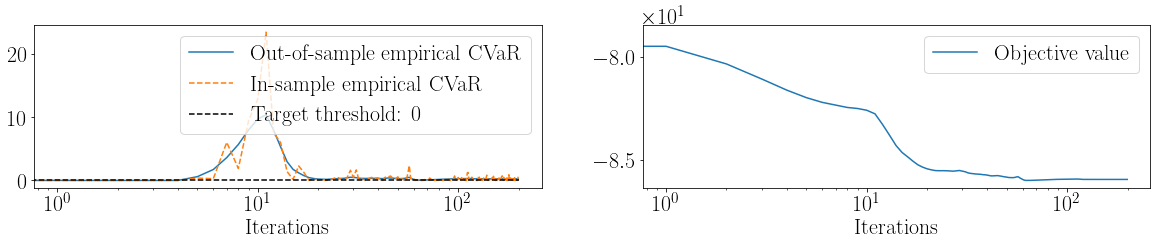

In [362]:
plot_iters(df1,"news")

In [70]:
prob_list = np.array([0.,0.01,0.05,0.1])
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Violations']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Violations']),axis = 1)-i).argmin())
st_eps = np.concatenate((np.linspace(0.6, 0.9, 60), np.linspace(0.93, 2.5, 15)))[inds_standard[0]]
re_eps = np.concatenate((np.linspace(0.6, 0.9, 60), np.linspace(0.93, 2.5, 15)))[inds_reshaped[0]]
st_eps, re_eps

(0.8440677966101695, 1.4907142857142857)

In [5]:
def plot_coverage_all(df_standard,df_reshape,dfs,title,ind_1 = (0,100), ind_2 = (0,100), logscale = True, legend = False, zoom = False):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    beg1,end1 = ind_1
    beg2,end2 = ind_2

    fig, (ax, ax1,ax2) = plt.subplots(1, 3, figsize=(23, 3))
    
    ax.plot(np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax.fill(np.append(np.quantile(np.vstack(df_standard['Violations']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Violations']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.9,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax.plot(np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set")
    ax.fill(np.append(np.quantile(np.vstack(df_reshape['Violations']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Violations']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.9,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    ax.set_xlabel("Probability of constraint violation")
    ax.axvline(x = 0.03, color = "green", linestyle = "-.",label = r"$\eta = 0.03$")
    ax.set_ylabel("Objective value")
    ax.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax.set_ylim([-300,800])

    # ax.legend()

    ax1.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax1.fill(np.append(np.quantile(np.vstack(df_standard['coverage_test']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['coverage_test']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.90,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax1.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",label=r"Decision-Focused set")
    ax1.fill(np.append(np.quantile(np.vstack(df_reshape['coverage_test']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['coverage_test']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.90,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    if dfs:
        for i in range(5):
            ax1.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Test_val']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax1.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")

    ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax1.set_ylim([-300,800])
    ax1.axvline(x = 0.8, color = "black", linestyle = ":",label = "0.8 Coverage")

    if logscale:
        ax1.set_xscale("log")
    ax1.set_xlabel("Test set coverage")
    ax1.set_ylabel("Objective value")
    # ax1.legend()

    ax2.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")

    ax2.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set",alpha = 0.8)
    if dfs:
        for i in range(5):
            ax2.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Violations']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax2.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Violations']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")
    # ax2.plot(np.arange(100)/100, 1 - np.arange(100)/100, color = "red")
    ax2.axvline(x = 0.8, color = "black",linestyle = ":", label = "0.8 Coverage")
    ax2.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
    ax2.set_ylabel("Prob. of cons. vio.")
    ax2.set_xlabel("Test set coverage")
    if zoom:
        axins = zoomed_inset_axes(ax2, 6, loc="upper center")
        axins.set_xlim(-0.005, 0.1)
        axins.set_ylim(-0.003,0.05)
        axins.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue")
        axins.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange",alpha = 0.8)
        axins.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
        axins.set_xticks(ticks=[])
        axins.set_yticks(ticks=[])
        mark_inset(ax2, axins, loc1=3, loc2=4, fc="none", ec="0.5")
    if logscale:
        ax2.set_xscale("log")
    # ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax2.legend()
    if legend:
        ax2.legend(bbox_to_anchor=(-1.8, -0.6, 0, 0), loc="lower left",
                 borderaxespad=0, ncol=4, fontsize = 24)

    # lines_labels = [ax.get_legend_handles_labels()]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels,loc='upper center', ncol=2,bbox_to_anchor=(0.5, 1.2))
    plt.savefig(title+"_curves.pdf",bbox_inches='tight')
    plt.show()

In [63]:
def plot_coverage(df_standard,df_reshape,dfs,title,ind_1 = (0,100), ind_2 = (0,100), logscale = True):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    beg1,end1 = ind_1
    beg2,end2 = ind_2

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
    ax1.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Standard set")
    ax1.fill(np.append(np.quantile(np.vstack(df_standard['coverage_test']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['coverage_test']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.90,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax1.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",label=r"Reshaped set")
    ax1.fill(np.append(np.quantile(np.vstack(df_reshape['coverage_test']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['coverage_test']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.90,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    if dfs:
        for i in range(5):
            ax1.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Test_val']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax1.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")

    ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    if logscale:
        ax1.set_xscale("log")
    ax1.set_xlabel("Test set coverage")
    ax1.set_ylabel("Objective value")
    ax1.legend()

    ax2.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue", label=r"Standard set")

    ax2.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set",alpha = 0.8)
    if dfs:
        for i in range(5):
            ax2.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Violations']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax2.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Violations']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")
    # ax2.plot(np.arange(100)/100, 1 - np.arange(100)/100, color = "red")
    # ax2.set_ylim([-0.05,0.25])
    ax2.set_ylabel("Prob. of cons. vio.")
    ax2.set_xlabel("Test set coverage")
    if logscale:
        ax2.set_xscale("log")
    # ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax2.legend()
    # plt.savefig(title+"_curve.pdf",bbox_inches='tight')
    plt.show()

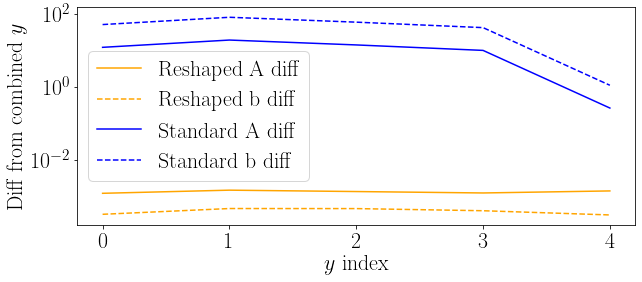

In [ ]:
diffs = np.zeros((4,5))
for i in range(5):
  diffs[0,i] = np.mean(np.abs(A_y[i+1][0] -  A_y[0][0]))
  diffs[1,i] = np.mean(np.abs(A_y[i+1][1] -  A_y[0][1]))
  diffs[2,i] = np.mean(np.abs(A_y[i+1][2] -  A_y[0][2]))
  diffs[3,i] = np.mean(np.abs(A_y[i+1][3] -  A_y[0][3]))
plt.figure(figsize=(10, 4))
plt.plot(diffs[0], color = "orange", label = "Reshaped A diff")
plt.plot(diffs[1], color = "orange", linestyle = "--", label = "Reshaped b diff")
plt.plot(diffs[2], color = "blue", label = "Standard A diff")
plt.plot(diffs[3], color = "blue",linestyle = "--", label = "Standard b diff")
plt.xlabel("$y$ index")
plt.ylabel("Diff from combined $y$")
plt.yscale("log")
plt.legend()
plt.show()

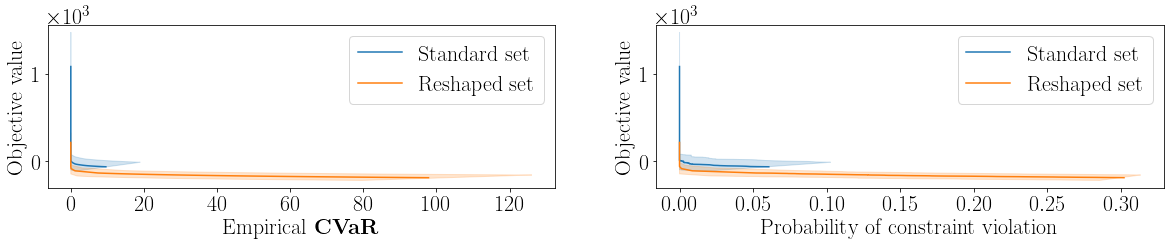

In [126]:
plot_tradeoff(dfgrid,dfgrid2,"News",ind_1=(0,100),ind_2=(0,100) )

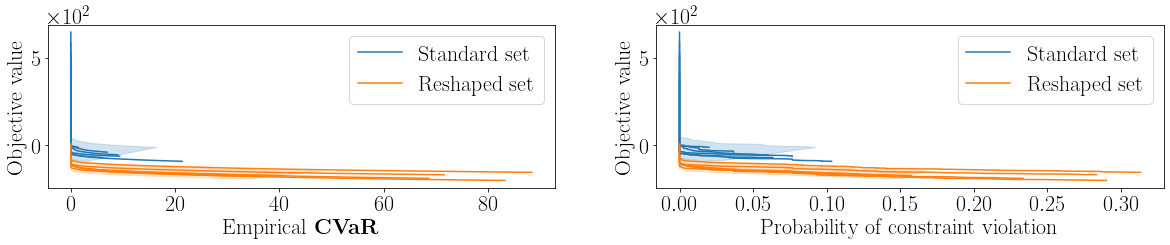

In [64]:
plot_tradeoff(dfs[0][0],dfs[0][1],dfs,"News",ind_1=(0,100),ind_2=(0,100) )

In [63]:
def plot_tradeoff(df_standard,df_reshape,dfs, title,ind_1 = (0,100), ind_2 = (0,100)):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    beg1,end1 = ind_1
    beg2,end2 = ind_2

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
    ax1.plot(np.mean(np.vstack(df_standard['Violation_val']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Standard set")
    ax1.fill(np.append(np.quantile(np.vstack(df_standard['Violation_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Violation_val']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.01,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.99,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax1.plot(np.mean(np.vstack(df_reshape['Violation_val']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",label=r"Reshaped set")
    ax1.fill(np.append(np.quantile(np.vstack(df_reshape['Violation_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Violation_val']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.01,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.99,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)

    for i in range(5):
        ax1.plot(np.mean(np.vstack(dfs[i+1][0]['Violation_val']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Test_val']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
        ax1.plot(np.mean(np.vstack(dfs[i+1][1]['Violation_val']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")

    ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax1.set_xlabel("Empirical $\mathbf{CVaR}$")
    ax1.set_ylabel("Objective value")
    ax1.legend()

    ax2.plot(np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Standard set")
    ax2.fill(np.append(np.quantile(np.vstack(df_standard['Violations']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Violations']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.01,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.99,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax2.plot(np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set")
    ax2.fill(np.append(np.quantile(np.vstack(df_reshape['Violations']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Violations']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.01,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.99,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    for i in range(5):
        ax2.plot(np.mean(np.vstack(dfs[i+1][0]['Violations']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Test_val']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
        ax2.plot(np.mean(np.vstack(dfs[i+1][1]['Violations']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")
    ax2.set_xlabel("Probability of constraint violation")
    ax2.set_ylabel("Objective value")
    ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax2.legend()
    # plt.savefig(title+"_curve.pdf",bbox_inches='tight')
    plt.show()

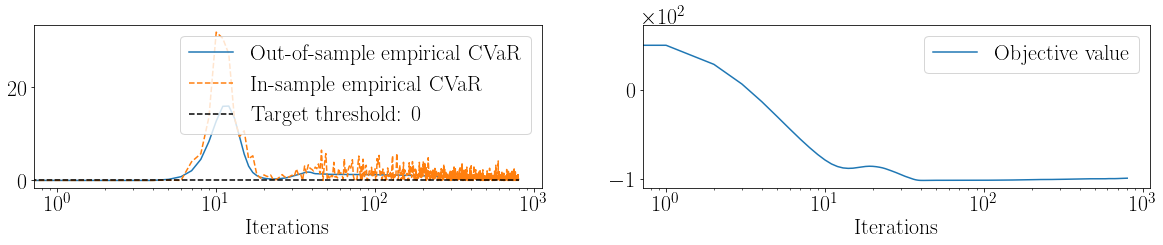

In [10]:
plot_iters(df1,"News", steps = 800,logscale = 1)

In [13]:
def eval(t,y,x, x1, p1, p,data):
    t = torch.tensor(t)
    y = torch.tensor(y)
    x = torch.tensor(x)
    x1 = torch.tensor(x1)
    p_tch = torch.tensor(p)
    p1 = torch.tensor(p1)
    data = torch.tensor(data)
    return 0.5*torch.mean((torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True))>=0.0001).float()) + 0.5*torch.mean((torch.maximum(
        torch.maximum(k1_tch@x1 -data@p1, k1_tch@x1 - p1@x1) - y, 
        torch.tensor(0.,requires_grad = True))>=0.0001).float())

def eval(t,y,x, x1, p1, p,data):
    t = torch.tensor(t)
    y = torch.tensor(y)
    x = torch.tensor(x)
    x1 = torch.tensor(x1)
    p = torch.tensor(p)
    p1 = torch.tensor(p1)
    data = torch.tensor(data)
    Nsample = data.shape[0]
    return torch.sum((torch.maximum(torch.maximum(
        torch.maximum(k_tch@x -data@p, k_tch@x - p@x) - t, 
        torch.tensor(0.,requires_grad = True)), 
        torch.maximum(k1_tch@x1 -data@p1, k1_tch@x1 - p1@x1) - y))>= torch.tensor(1.))/Nsample

def make_table(result_A,result_b, dfgrid,test, train, value,eps):
    trial1 = np.zeros((num_scenarios,6))
    for scene in range(num_scenarios):
        # formulate the ellipsoidal set
        if eps:
          r_eps = 1
        else:
          r_eps = dfgrid['Eps'][np.absolute(np.mean(np.vstack(dfgrid['Violations_train']),axis = 1)-value).argmin()]
        u = lropt.UncertainParameter(n,
                                    uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                    rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))
        # Formulate the Robust Problem
        x_r = cp.Variable(n)
        x_1 = cp.Variable(n)
        t = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter(n)
        # p1 = cp.Parameter(n)
        p.value = scenarios[scene][0]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t+y)

        constraints = [cp.maximum(k@x_r - p@x_r - t, k@x_r - p@u - t,k1@x_1 - p1@x_1 - y,  k1@x_1 - p1@u - y) <= 0]
        # constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
        # constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]

        constraints += [x_1 >= 0, x_r >= x_1]

        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()

        coverage = 0
        for datind in range(test.shape[0]):
            coverage += np.where(np.linalg.norm((1/r_eps)*result_A@test[datind] + (1/r_eps)*result_b)<= 1, 1, 0 )
        coverage_train = 0
        for datind in range(train.shape[0]):
            coverage_train += np.where(np.linalg.norm((1/r_eps)*result_A@train[datind] + (1/r_eps)*result_b)<= 1, 1, 0 )

        trial1[scene,0] = torch.mean(
        torch.maximum(k_tch@torch.tensor(x_r.value) -torch.tensor(test)@p_tch, k_tch@torch.tensor(x_r.value) - p_tch@torch.tensor(x_r.value))+ torch.maximum(k1_tch@torch.tensor(x_1.value) -torch.tensor(test)@p1_tch, k1_tch@torch.tensor(x_1.value) - p1_tch@torch.tensor(x_1.value)))
        trial1[scene,1] = eval(t.value,y.value,x_r.value, x_1.value,p1,p.value,test).item()
        trial1[scene,2] = eval(t.value,y.value,x_r.value, x_1.value,p1,p.value,train).item()
        trial1[scene,3] = coverage/test.shape[0]
        trial1[scene,4] = coverage_train/train.shape[0]
        trial1[scene,5] = newprob.solver_stats.solve_time
        # trial1[scene,6] = np.linalg.det(sc.linalg.inv((1/r_eps)*result_A@((1/r_eps)*result_A)))**0.5
    return trial1
def mro(train, test, K = 300, rho = 1):
    vios = np.zeros((num_scenarios))
    vios_1 = np.zeros((num_scenarios))
    objs = np.zeros((num_scenarios))
    time = np.zeros((num_scenarios))
    for scene in range(num_scenarios):
        u = lropt.UncertainParameter(n,
                                          uncertainty_set = lropt.MRO(train = False, data = train, rho = rho, A = None, K = K))
            # Formulate the Robust Problem
        x_r = cp.Variable(n)
        x_1 = cp.Variable(n)
        t = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter(n)
        # p1 = cp.Parameter(n)
        p.value = scenarios[scene][0]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t+y)

        constraints = [cp.maximum(k@x_r - p@x_r - t, k@x_r - p@u - t,k1@x_1 - p1@x_1 - y,  k1@x_1 - p1@u - y) <= 0]

        constraints += [x_1 >= 0, x_r >= x_1]


        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        objs[scene] = torch.mean(
        torch.maximum(k_tch@torch.tensor(x_r.value) -torch.tensor(test)@torch.tensor(p.value), k_tch@torch.tensor(x_r.value) - torch.tensor(p.value)@torch.tensor(x_r.value))+ torch.maximum(k1_tch@torch.tensor(x_1.value) -torch.tensor(test)@p1_tch, k1_tch@torch.tensor(x_1.value) - p1_tch@torch.tensor(x_1.value)))
        vios[scene] = eval(t.value,y.value,x_r.value, x_1.value,p1,p.value,test).item()
        vios_1[scene] = eval(t.value,y.value,x_r.value, x_1.value,p1,p.value,train).item()
        time[scene] = newprob.solver_stats.solve_time
    return vios, vios_1, objs, time


def sg(train, test):
    vios = np.zeros((num_scenarios))
    objs = np.zeros((num_scenarios))
    time = np.zeros((num_scenarios))
    for scene in range(num_scenarios):
            # Formulate the Robust Problem
        x_r = cp.Variable(n)
        x_1 = cp.Variable(n)
        t = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter(n)
        # p1 = cp.Parameter(n)
        p.value = scenarios[scene][0]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t+y)
        constraints = [x_r >= 0, x_r >= x_1]
        for u in train:
          constraints += [cp.maximum(k@x_r - p@x_r - t, k@x_r - p@u - t,k1@x_1 - p1@x_1 - y,  k1@x_1 - p1@u - y) <= 0]
          # constraints += [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
          # constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]
        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        objs[scene] = prob.objective.value
        vios[scene] = eval(t.value,y.value,x_r.value, x_1.value,p1,p.value,test).item()
        time[scene] = prob.solver_stats.solve_time
    return vios, objs, time

In [30]:
Ar_saved = np.zeros((100,n,n))
br_saved = np.zeros((100,n))
# As_saved = np.zeros((100,15,15))
# bs_saved = np.zeros((100,15))
reshaped_table6 = np.zeros((1,18))
standard_table6 = np.zeros((1,18))
for experiment in range(20):
    np.random.seed(experiment)
    data = np.exp(np.random.multivariate_normal(mu,sig, N*2))
    # Formulate uncertainty set
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Ellipsoidal(p=2,
                                                        data=data, loss = loss))
    # Formulate the Robust Problem
    x_r = cp.Variable(n)
    x_1 = cp.Variable(n)
    t = cp.Variable()
    y = cp.Variable()
    p = cp.Parameter(n)
    # p1 = cp.Parameter(n)
    p.value = scenarios[0][0]
    # p1.value = scenarios[0][1]
    objective = cp.Minimize(t+y)

    constraints = [cp.maximum(k@x_r - p@x_r - t, k@x_r - p@u - t,k1@x_1 - p1@x_1 - y,  k1@x_1 - p1@u - y) <= 0]

    constraints += [x_r >= 0, x_r >= x_1]

    prob = lropt.RobustProblem(objective, constraints)
    target = -0.05
    test_p = 0.5
    s = 5
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
    init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
    init_bval = -init@np.mean(train, axis=0)
    # Train A and b
    result1 = prob.train(lr = 0.000001, step=800, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False,init_lam = 0.1, target_cvar = target, init_alpha = 0., test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.01)
    df1 = result1.df
    A_fin = result1.A
    b_fin = result1.b
    Ar_saved[experiment,:] = A_fin
    br_saved[experiment,:] = b_fin

    # result3 = prob.train(eps = True, lr = 0.00001, step=800, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_mu = 1, init_lam = 0,  target_cvar = target, init_alpha =0.,mu_multiplier = 1.01,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    # df_r2 = result3.df
    # As_saved[experiment,:] = result3.A
    # bs_saved[experiment,:] = result3.b

    # Grid search epsilon
    result4 = prob.grid(epslst = np.concatenate((np.linspace(0.6, 0.9, 60), np.linspace(0.93, 2.5, 15))), init_A = init, init_b = init_bval, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid = result4.df

    result5 = prob.grid(epslst = np.concatenate((np.linspace(0.01, 0.6, 60), np.linspace(0.61, 2.5, 15))), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid2 = result5.df

    r_t = make_table(A_fin, b_fin, dfgrid2,test,train,0.03, eps = 0)
    r_t1 = make_table(A_fin, b_fin, dfgrid2,test,train,0., eps = 1)
    r_t2 = make_table(A_fin, b_fin, dfgrid2,test,train,0.04, eps = 0)
    r_t = np.hstack((r_t, r_t1, r_t2))
    
    reshaped_table6 = np.vstack((reshaped_table6, r_t))

    s_t = make_table(init, init_bval, dfgrid,test, train,0.03, eps = 0)
    s_t1 = make_table(init, init_bval, dfgrid,test, train,0., eps = 1)
    s_t2 = make_table(init, init_bval, dfgrid,test, train,0.04, eps = 0)
    s_t = np.hstack((s_t, s_t1, s_t2))
    standard_table6 = np.vstack((standard_table6, s_t))
    pd.DataFrame(standard_table6).to_csv("standard_table_6.csv")
    pd.DataFrame(reshaped_table6).to_csv("reshaped_table_6.csv")
    np.save("Ar_saved6.npy", Ar_saved)
    # np.save("As_saved.npy", As_saved)
    np.save("br_saved6.npy", br_saved)
    # np.save("bs_saved.npy", bs_saved)
# standard_table = pd.read_csv("standard_table_1.csv").iloc[:,1:]
# reshaped_table = pd.read_csv("reshaped_table_1.csv").iloc[:,1:]
# standard_table = standard_table.values
# reshaped_table = reshaped_table.values
# pd.DataFrame(standard_table).to_csv("standard_table_1.csv")
# pd.DataFrame(reshaped_table).to_csv("reshaped_table_1.csv")
reshaped_table6 = reshaped_table6[1:]
standard_table6 = standard_table6[1:]

In [5]:
standard_table = pd.read_csv("standard_table_6.csv").iloc[1:,1:]
reshaped_table = pd.read_csv("reshaped_table_6.csv").iloc[1:,1:]
standard_table = standard_table.values
reshaped_table = reshaped_table.values

In [3]:
targets = [0.03,0]
def printresults(table,targets,N):
  for i in range(2):
    print("test_vio_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6 + 1].reshape(-1, 5), axis=1)))
    print("train_vio_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6 + 2].reshape(-1, 5), axis=1)))
    print("test_obj_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6].reshape(-1, 5), axis=1)))
    print("train_coverage " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+4].reshape(-1, 5), axis=1)/N))
    print("test_coverage " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+3].reshape(-1, 5), axis=1)/N))
    print("solve time " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+5].reshape(-1, 5), axis=1)))
    print(" ")

In [72]:
#15: 300 600 150, 10: 300 600 150, 
printresults(reshaped_table,targets,300)
printresults(reshaped_table1,targets,600)
printresults(reshaped_table2,targets,150)

printresults(reshaped_table3,targets,300)
printresults(reshaped_table4,targets,600)
printresults(reshaped_table5,targets,150)

printresults(reshaped_table6,targets,300)
printresults(reshaped_table7,targets,600)
printresults(reshaped_table8,targets,150)

test_vio_target 0.03:  0.02856666687875986
train_vio_target 0.03:  0.029833333310671156
test_obj_target 0.03:  -120.75668912847873
train_coverage 0.03:  0.0
test_coverage 0.03:  0.0
solve time 0.03:  0.00055679667
 
test_vio_target 0:  0.0050999999884516
train_vio_target 0:  0.005166666661389173
test_obj_target 0:  -95.21471946207674
train_coverage 0:  0.0
test_coverage 0:  0.0
solve time 0:  0.00062242457
 
test_vio_target 0.03:  0.030633333406876774
train_vio_target 0.03:  0.02880000004312024
test_obj_target 0.03:  -121.66822505126856
train_coverage 0.03:  0.0
test_coverage 0.03:  0.0
solve time 0.03:  0.00052737836
 
test_vio_target 0:  0.006299999987240882
train_vio_target 0:  0.00505000002682209
test_obj_target 0:  -97.55621694091653
train_coverage 0:  0.0
test_coverage 0:  0.0
solve time 0:  0.0005579400299999999
 
test_vio_target 0.03:  0.03146666692569852
train_vio_target 0.03:  0.030866666669026016
test_obj_target 0.03:  -118.68057259585862
train_coverage 0.03:  0.0
test_cover

In [73]:
printresults(standard_table,targets,300)
printresults(standard_table1,targets,600)
printresults(standard_table2,targets,150)
printresults(standard_table3,targets,300)
printresults(standard_table4,targets,600)
printresults(standard_table5,targets,150)
printresults(standard_table6,targets,300)
printresults(standard_table7,targets,600)
printresults(standard_table8,targets,150)

test_vio_target 0.03:  0.0278666667221114
train_vio_target 0.03:  0.028833333472721275
test_obj_target 0.03:  -52.38154771292843
train_coverage 0.03:  0.0
test_coverage 0.03:  0.0
solve time 0.03:  0.00061242081
 
test_vio_target 0:  0.005200000056065619
train_vio_target 0:  0.004133333303034306
test_obj_target 0:  6.813157489474446
train_coverage 0:  0.0
test_coverage 0:  0.0
solve time 0:  0.00061268828
 
test_vio_target 0.03:  0.03091666682390496
train_vio_target 0.03:  0.02845000019297004
test_obj_target 0.03:  -52.16988847366125
train_coverage 0.03:  0.0
test_coverage 0.03:  0.0
solve time 0.03:  0.00058757791
 
test_vio_target 0:  0.0010833333409391345
train_vio_target 0:  0.0009000000101514162
test_obj_target 0:  28.179311089328298
train_coverage 0:  0.0
test_coverage 0:  0.0
solve time 0:  0.0006174771
 
test_vio_target 0.03:  0.02606666662730277
train_vio_target 0.03:  0.025933333626016974
test_obj_target 0.03:  -44.274702340774105
train_coverage 0.03:  0.0
test_coverage 0.03:

In [43]:
printresults(reshaped_table6,targets,1)

test_vio_target 0.03:  0.02950000007171184
train_vio_target 0.03:  0.02716666657477617
test_obj_target 0.03:  -40.07100683760926
train_coverage 0.03:  0.1295
test_coverage 0.03:  0.12449999999999999
solve time 0.03:  0.00014518078
 
test_vio_target 0:  0.013700000145472582
train_vio_target 0:  0.012533333483152092
test_obj_target 0:  -34.734169562557966
train_coverage 0:  0.2053333333333333
test_coverage 0:  0.19199999999999998
solve time 0:  0.00015039206
 


In [57]:
print("DRO = ", np.mean(totalvios, axis = 0)[5] , np.mean(totalobjs,axis = 0)[5], np.mean(totaltime, axis = 0)[5])
print("SG = ", np.mean(sg_vals[:,0]), np.mean(sg_vals[:,1]),np.mean(sg_vals[:,2]))
print(np.mean(np.mean(standard_table[:,1].reshape(-1, 5), axis=1) >= 0.05))
print(np.mean(np.mean(reshaped_table[:,1].reshape(-1, 5), axis=1) >= 0.05))
print(np.mean(sg_vals[:,0] >= 0.05))
print(np.mean(np.mean(totalvios[:,3].reshape(-1, 5), axis=1) > 0.05))

DRO =  0.00012000000197440385 -63.511619555785515 0.15704018218000024
SG =  0.001846666693687439 -150.85604686039022 0.016142951410000002
0.06
0.09
0.0
0.15


In [45]:
totalvios = np.zeros((num_scenarios*20,10))
totalvios_train =  np.zeros((num_scenarios*20,10))
totalobjs = np.zeros((num_scenarios*20,10))
totaltime = np.zeros((num_scenarios*20,10))
epsrange = np.linspace(0.1, 5, 10)
for experiment in range(20):
    print(experiment)
    np.random.seed(experiment)
    data = np.exp(np.random.multivariate_normal(mu,sig, N*2))
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=5)
    ind = 0
    for eps in epsrange:
        vios, vios1, objs, time = mro(train,test, K = 300, rho = eps)
        totalvios[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios 
        totalvios_train[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios1
        totalobjs[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = objs 
        totaltime[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = time
        ind += 1
        np.save("totalvios2.npy", totalvios)
        np.save("totalvios_train2.npy", totalvios_train)
        np.save("totalobjs2.npy", totalobjs)
        np.save("totaltime2.npy", totaltime)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [53]:
ind = 2
np.mean(totalvios, axis = 0)[ind], np.mean(totalobjs, axis = 0)[ind],np.mean(totaltime, axis = 0)[ind]
np.mean(np.mean(totalvios[:,ind].reshape(-1, 5), axis=1) >= 0.05)

(0.03086666683666408, -34.11686253077792, 0.056387075049999985)

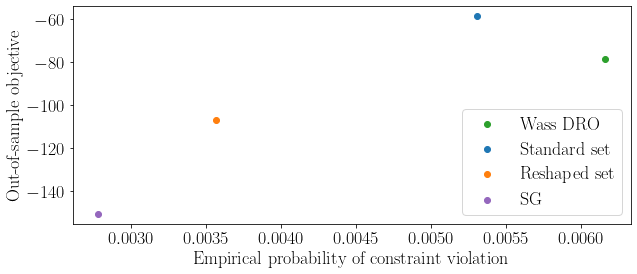

In [34]:
plt.figure(figsize = (10,4))
plt.scatter(np.mean(totalvios, axis = 0)[6] , np.mean(totalobjs,axis = 0)[6], color = "tab:green", label = " Wass DRO")
plt.scatter(np.mean(standard_table[:,4]), np.mean(standard_table[:,3]),label = "Standard set", color = "tab:blue")
plt.scatter(np.mean(reshaped_table[:,4]), np.mean(reshaped_table[:,3]),label = "Reshaped set", color = "tab:orange")
plt.scatter(np.mean(sg_vals[:,0]), np.mean(sg_vals[:,1]), label = "SG", color = "tab:purple")
plt.xlabel("Empirical probability of constraint violation")
plt.ylabel("Out-of-sample objective")
plt.legend()
plt.show()

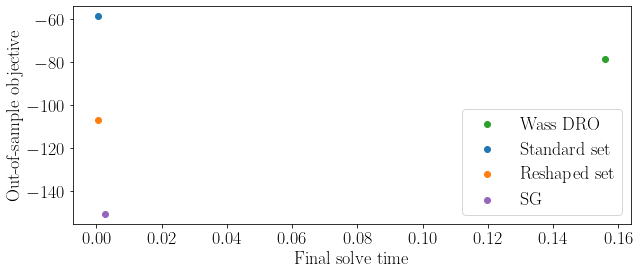

In [30]:
plt.figure(figsize = (10,4))
plt.scatter(np.mean(totaltime, axis = 0)[6] , np.mean(totalobjs,axis = 0)[6], color = "tab:green", label = " Wass DRO")
plt.scatter(np.mean(standard_table[:,5]), np.mean(standard_table[:,3]),label = "Standard set", color = "tab:blue")
plt.scatter(np.mean(reshaped_table[:,5]), np.mean(reshaped_table[:,3]),label = "Reshaped set", color = "tab:orange")
plt.scatter(np.mean(sg_vals[:,0]), np.mean(sg_vals[:,1]), label = "SG", color = "tab:purple")
plt.xlabel("Final solve time")
plt.ylabel("Out-of-sample objective")
plt.legend()
plt.show()

In [44]:
print("reshaped = ", np.mean(reshaped_table[:,4])*2, np.mean(reshaped_table[:,3]),np.mean(reshaped_table[:,5]))
print("standard = ", np.mean(standard_table[:,4])*2, np.mean(standard_table[:,3]),np.mean(standard_table[:,5]))
print("DRO = ", np.mean(totalvios, axis = 0)[6]*2 , np.mean(totalobjs,axis = 0)[6], np.mean(totaltime, axis = 0)[6])
print("SG = ", np.mean(sg_vals[:,0])*2, np.mean(sg_vals[:,1]),np.mean(sg_vals[:,2]))

reshaped =  0.007133671819577449 -107.06029972551575 0.0005262797705583757
standard =  0.010619289428941121 -58.56273194455417 0.0005685917939086294
DRO =  0.012326666741631924 -78.59854222394392 0.15599188118
SG =  0.005566666716709733 -150.8560468577561 0.012848807482


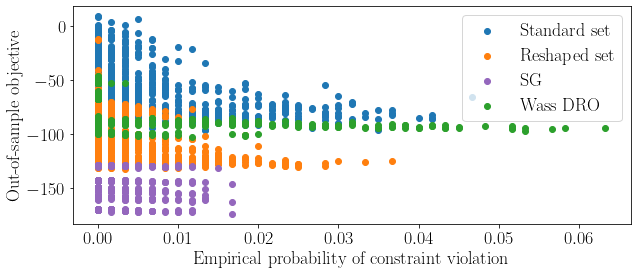

In [36]:
plt.figure(figsize = (10,4))
plt.scatter(standard_table[:,4], standard_table[:,3],label = "Standard set", color = "tab:blue")
plt.scatter(reshaped_table[:,4], reshaped_table[:,3],label = "Reshaped set", color = "tab:orange")
plt.scatter(sg_vals[:,0], sg_vals[:,1],label = "SG", color = "tab:purple")
plt.scatter(totalvios[:,6] ,totalobjs[:,6], color = "tab:green", label = " Wass DRO")
plt.xlabel("Empirical probability of constraint violation")
plt.ylabel("Out-of-sample objective")
plt.legend()
plt.show()

In [44]:
sg_vals = np.zeros((num_scenarios*100,3))
for experiment in range(100):
    print(experiment)
    np.random.seed(experiment)
    data = np.exp(np.random.multivariate_normal(mu,sig, N*2))
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=5)
    vios, objs, time = sg(train,test)
    sg_vals[(experiment*num_scenarios):((experiment+1)*num_scenarios),0] = vios 
    sg_vals[(experiment*num_scenarios):((experiment+1)*num_scenarios),1] = objs 
    sg_vals[(experiment*num_scenarios):((experiment+1)*num_scenarios),2] = time
    np.save("sg_vals1.npy", sg_vals)

0


KeyboardInterrupt: 

In [58]:
standard_table = pd.read_csv("standard_table_2.csv").iloc[:,1:].values
reshaped_table = pd.read_csv("reshaped_table_2.csv").iloc[:,1:].values
totalvios = np.load("totalvios2.npy")
totalvios_train = np.load("totalvios_train2.npy")
totalobjs = np.load("totalobjs2.npy")
totaltime = np.load("totaltime2.npy")
sg_vals = np.load("sg_vals1.npy")
reshaped_table = reshaped_table[1:]
standard_table = standard_table[1:]

In [60]:
table = np.zeros((4,6))
table[0,0] =  np.mean(np.mean(reshaped_table[:,6].reshape(-1, 5), axis=1))
table[1,0] =  np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1))
table[2,0] =  np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1) >= 0.05)
table[3,0] =  np.mean(np.mean(reshaped_table[:,11].reshape(-1, 5), axis=1))

table[0,1] =  np.mean(np.mean(reshaped_table[:,0].reshape(-1, 5), axis=1))
table[1,1] =  np.mean(np.mean(reshaped_table[:,1].reshape(-1, 5), axis=1))
table[2,1] =  np.mean(np.mean(reshaped_table[:,1].reshape(-1, 5), axis=1) >= 0.05)
table[3,1] =  np.mean(np.mean(reshaped_table[:,5].reshape(-1, 5), axis=1))

table[0,2] =  np.mean(np.mean(standard_table[:,6].reshape(-1, 5), axis=1))
table[1,2] =  np.mean(np.mean(standard_table[:,7].reshape(-1, 5), axis=1))
table[2,2] =  np.mean(np.mean(standard_table[:,7].reshape(-1, 5), axis=1) >= 0.05)
table[3,2] =  np.mean(np.mean(standard_table[:,11].reshape(-1, 5), axis=1))

table[0,3] =  np.mean(np.mean(standard_table[:,0].reshape(-1, 5), axis=1))
table[1,3] =  np.mean(np.mean(standard_table[:,1].reshape(-1, 5), axis=1))
table[2,3] =  np.mean(np.mean(standard_table[:,1].reshape(-1, 5), axis=1) >= 0.05)
table[3,3] =  np.mean(np.mean(standard_table[:,5].reshape(-1, 5), axis=1))

table[0,4] =  np.mean(totalobjs,axis = 0)[3]
table[1,4] =  np.mean(totalvios, axis = 0)[3]
table[2,4] =  np.mean(np.mean(totalvios[:,3].reshape(-1, 5), axis=1) >= 0.05)
table[3,4] =  np.mean(totaltime, axis = 0)[3]

table[0,5] =  np.mean(sg_vals[:,1])
table[1,5] =  np.mean(sg_vals[:,0])
table[2,5] =  np.mean(sg_vals[:,0] >= 0.05)
table[3,5] =  np.mean(sg_vals[:,2])
pd.DataFrame(table).to_csv("table_vals3.csv")
